In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

This notebook contains the code samples found in Chapter 3, Section 5 of Deep Learning with Python. Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.




# Classifying newswires: a multi-class classification example

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. But what happens when you have more than two classes?

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.


# The Reuters datase

We will be working with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


Like with the IMDB dataset, the argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.

We have 8,982 training examples and 2,246 test examples:

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [8]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [9]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [10]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [13]:
# The label associated with an example is an integer between 0 and 45: a topic index.
train_labels[10]

3

# Preparing the data

In [15]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding"

One hot encoding of labels

In [16]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [49]:
one_hot_train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Building our network

This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the dimensionality of the output space is much larger.


In a stack of Dense layers like what we were using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [18]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Validating our approach

In [20]:
#Let's set apart 1,000 samples in our training data to use as a validation set:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [21]:
train_labels

array([ 3,  4,  3, ..., 25,  3, 25])

In [22]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 154us/step - loss: 2.5515 - accuracy: 0.5170 - val_loss: 1.7040 - val_accuracy: 0.6440
Epoch 2/20
7982/7982 [==============================] - 1s 114us/step - loss: 1.3931 - accuracy: 0.7187 - val_loss: 1.2813 - val_accuracy: 0.7310
Epoch 3/20
7982/7982 [==============================] - 1s 114us/step - loss: 1.0345 - accuracy: 0.7821 - val_loss: 1.1139 - val_accuracy: 0.7620
Epoch 4/20
7982/7982 [==============================] - 1s 114us/step - loss: 0.8153 - accuracy: 0.8261 - val_loss: 1.0421 - val_accuracy: 0.7760
Epoch 5/20
7982/7982 [==============================] - 1s 113us/step - loss: 0.6527 - accuracy: 0.8632 - val_loss: 0.9614 - val_accuracy: 0.8000
Epoch 6/20
7982/7982 [==============================] - 1s 115us/step - loss: 0.5205 - accuracy: 0.8938 - val_loss: 0.9294 - val_accuracy: 0.8110
Epoch 7/20
7982/7982 [==============================] - 1s 116us/step - loss

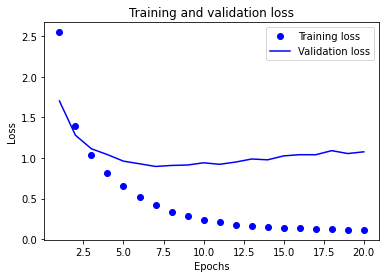

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

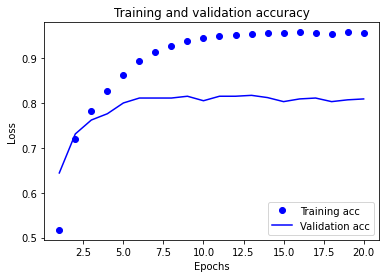

In [25]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on the test set:

In [47]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 121us/step - loss: 2.5217 - accuracy: 0.5347 - val_loss: 1.6693 - val_accuracy: 0.6370
Epoch 2/8
7982/7982 [==============================] - 1s 112us/step - loss: 1.3740 - accuracy: 0.7052 - val_loss: 1.2833 - val_accuracy: 0.7140
Epoch 3/8
7982/7982 [==============================] - 1s 115us/step - loss: 1.0251 - accuracy: 0.7793 - val_loss: 1.1201 - val_accuracy: 0.7540
Epoch 4/8
7982/7982 [==============================] - 1s 112us/step - loss: 0.8079 - accuracy: 0.8306 - val_loss: 1.0267 - val_accuracy: 0.7900
Epoch 5/8
7982/7982 [==============================] - 1s 113us/step - loss: 0.6370 - accuracy: 0.8663 - val_loss: 0.9560 - val_accuracy: 0.8010
Epoch 6/8
7982/7982 [==============================] - 1s 113us/step - loss: 0.5077 - accuracy: 0.8941 - val_loss: 0.9139 - val_accuracy: 0.8040
Epoch 7/8
7982/7982 [==============================] - 1s 115us/step - loss: 0.403

In [46]:
results

[1.829051171682397, 0.5503116846084595]

Our approach reaches an accuracy of ~75%. 

# Generating predictions on new data

In [28]:
predictions = model.predict(x_test)

In [29]:
predictions[0].shape

(46,)

In [30]:
np.sum(predictions[0])

1.0000001

In [31]:
np.argmax(predictions[0])

3

In [36]:
test_labels

array([ 3, 10,  1, ...,  3,  3, 24])

In [39]:
test_labels[0]

3

# On the importance of having sufficiently large intermediate layers¶

We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 46-dimensional, e.g. 4-dimensional.

In [48]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 149us/step - loss: 2.6896 - accuracy: 0.3558 - val_loss: 1.9455 - val_accuracy: 0.5150
Epoch 2/20
7982/7982 [==============================] - 1s 149us/step - loss: 1.6082 - accuracy: 0.5948 - val_loss: 1.4929 - val_accuracy: 0.6310
Epoch 3/20
7982/7982 [==============================] - 1s 155us/step - loss: 1.2619 - accuracy: 0.6907 - val_loss: 1.3668 - val_accuracy: 0.6920
Epoch 4/20
7982/7982 [==============================] - 1s 153us/step - loss: 1.0817 - accuracy: 0.7375 - val_loss: 1.3353 - val_accuracy: 0.6870
Epoch 5/20
7982/7982 [==============================] - 1s 157us/step - loss: 0.9652 - accuracy: 0.7509 - val_loss: 1.2791 - val_accuracy: 0.7030
Epoch 6/20
7982/7982 [==============================] - 1s 152us/step - loss: 0.8780 - accuracy: 0.7679 - val_loss: 1.2952 - val_accuracy: 0.7050
Epoch 7/20
7982/7982 [==============================] - 1s 157us/step - loss

Our network now seems to peak at ~71% test accuracy, a 9% absolute drop.

# Summary 

Here's what you should take away from this example:

- If you are trying to classify data points between N classes, your network should end with a Dense layer of size N.

- In a single-label, multi-class classification problem, your network should end with a softmax activation, so that it will output a probability distribution over the N output classes.

- Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the network, and the true distribution of the targets.

- There are two ways to handle labels in multi-class classification: Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using categorical_crossentropy as your loss function. Encoding the labels as integers and using the sparse_categorical_crossentropy loss function.

- If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having intermediate layers that are too small.